# Pronostico 2022 - 2026 Maximos Potencia Aparente ET SAN FRANCISCO  Fecha: 13/10/2021 12:55

NOTAS:
Se dispone de los datos del SITEC ordenados cada 15 minutos por Estacion 

1. La demanda en 13 KV del SITEC es la que soportan los trafos de la ET mas la Generacion.
   Por tanto, los trafos soportan lo que transforma cada uno de 132 a 13 KV.

2. Leer la tabla 3 de Transformadores (Guia de Referencia) y colocar ese pronostico como alternativo

3. Detectar automaticamente los Outliers o Atipicos (LISTO)

INFORME
 
1. Al informe se lo presento en word o lo presento con nbviewer

2. Si lo presento con word, tengo que pasar Tablaxls a Excel

NO AHORA

.- Anibal tiene que agregar al Grupo San Francisco la linea SFCO - LAS VARILLAS


## Seteo Inicial

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Viernes 8 Octubre 2021 17:43:11 

@author: Daniel Busso
"""

# Plantilla de Pre Procesado

# Cómo importar las librerías
import numpy    as np
import pandas   as pd
import datetime as dt
import os

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

#from statsmodels.graphics.tsaplots import plot_acf
#from statsmodels.graphics.tsaplots import plot_pacf


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import mean_absolute_percentage_error

#from skforecast.ForecasterAutoreg import ForecasterAutoreg
#from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
#from skforecast.model_selection import grid_search_forecaster
#from skforecast.model_selection import time_series_spliter
#from skforecast.model_selection import cv_forecaster
#from skforecast.model_selection import backtesting_forecaster
#from skforecast.model_selection import backtesting_forecaster_intervals

In [3]:
# Configuracion Pandas

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', '{:.2f}'.format)

## Lectura Demandas en 13 Kv San Francisco
Lectura y creacion del index DateTime para tratar el DataFrame como una Serie de Tiempo

In [4]:
def conversion_2400(fecha):
    if fecha[11:13] != '24':
        return pd.to_datetime(fecha, format='%d/%m/%Y %H:%M')

    fecha = fecha[0:11] + '00:' + fecha[14:]
    return pd.to_datetime(fecha, format='%d/%m/%Y %H:%M') + dt.timedelta(days=1)

In [5]:
# EMPIEZO PROCESANDO UNA CARPETA
# AUTOMATIZAR LECTURAS DE VARIOS ARCHIVOS .PRN ANUALES
# lEER Y CONCATENAR LOS ARCHIVOS .prn DE LA CARPETA DSPractica/eetts/sanfrancisco

import os
import sys
from pathlib import Path

# ELEGIR PLATAFORMA WINDOWS LOCAL O GOOGLE COLABORATORY (la Nube)
if sys.platform == 'linux' :
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  carpeta_trabajo = Path('/content/drive/Othercomputers/LENOVO/DSPractica/eetts/san_francisco/Demanda_13') # Google Colab
else:
  carpeta_inicio  = Path.home()
  carpeta_eett = Path("DSPractica/eetts/san_francisco/Demanda_13")
  carpeta_trabajo = carpeta_inicio / carpeta_eett

archivos = list(carpeta_trabajo.glob('*.prn'))

# Automatizacion de los DataFrames 
dfconca = pd.DataFrame([])
for nombre_completo in archivos:
    dfdatos = pd.read_fwf(nombre_completo, header=0, decimal=',')
    dfconca = pd.concat([dfconca, dfdatos], ignore_index=True)
    

In [6]:
archivos

[WindowsPath('C:/Users/daniel/DSPractica/eetts/san_francisco/Demanda_13/MED_DEM_SANFCO13_2010_1201.prn'),
 WindowsPath('C:/Users/daniel/DSPractica/eetts/san_francisco/Demanda_13/MED_DEM_SANFCO13_2011_1200.prn'),
 WindowsPath('C:/Users/daniel/DSPractica/eetts/san_francisco/Demanda_13/MED_DEM_SANFCO13_2012_1159.prn'),
 WindowsPath('C:/Users/daniel/DSPractica/eetts/san_francisco/Demanda_13/MED_DEM_SANFCO13_2013_1157.prn'),
 WindowsPath('C:/Users/daniel/DSPractica/eetts/san_francisco/Demanda_13/MED_DEM_SANFCO13_2014_1156.prn'),
 WindowsPath('C:/Users/daniel/DSPractica/eetts/san_francisco/Demanda_13/MED_DEM_SANFCO13_2015_1154.prn'),
 WindowsPath('C:/Users/daniel/DSPractica/eetts/san_francisco/Demanda_13/MED_DEM_SANFCO13_2016_1152.prn'),
 WindowsPath('C:/Users/daniel/DSPractica/eetts/san_francisco/Demanda_13/MED_DEM_SANFCO13_2017_1151.prn'),
 WindowsPath('C:/Users/daniel/DSPractica/eetts/san_francisco/Demanda_13/MED_DEM_SANFCO13_2018_1150.prn'),
 WindowsPath('C:/Users/daniel/DSPractica/eetts

In [7]:
#
# BORRAMOS COLUMNAS NO USADAS
#

del dfconca['Ampere']
del dfconca['KVolt']

In [8]:
# GENERAMOS INDICE DE FECHAS PARA MANEJAR LA SERIE DE TIEMPO

dfconca['Fecha_Hora'] = dfconca['Fecha'] + ' ' + dfconca['Hora']
dfconca['Fecha_Hora'] = dfconca.Fecha_Hora.apply(conversion_2400) # CONVERSION DE HORA 24:00 ---> 00:00

dfconca.set_index('Fecha_Hora', inplace=True)
serie     = dfconca.drop(dfconca.index[-1]) # borro la fila del nuevo anio
serie_ord = serie.sort_index()

datos = serie_ord.copy()
demandas = datos.copy()
demandas

,Fecha,Hora,MW,MVAR,MVA
Fecha_Hora,,,,,
2010-01-01 00:15:00,01/01/2010,00:15,15.80,7.13,17.33
2010-01-01 00:30:00,01/01/2010,00:30,15.63,6.82,17.05
2010-01-01 00:45:00,01/01/2010,00:45,15.49,6.80,16.91
2010-01-01 01:00:00,01/01/2010,01:00,15.55,6.81,16.98
2010-01-01 01:15:00,01/01/2010,01:15,15.50,6.82,16.93
...,...,...,...,...,...
2021-12-31 22:45:00,31/12/2021,22:45,23.42,-2.79,23.58
2021-12-31 23:00:00,31/12/2021,23:00,23.25,-2.69,23.41
2021-12-31 23:15:00,31/12/2021,23:15,22.86,-3.06,23.07


## Depuracion

### Duplicados

In [9]:
if datos.index.has_duplicates:
    print('SI TIENE DUPLICADOS')
else:
    print('NO TIENE DUPLICADOS')

NO TIENE DUPLICADOS


### Chequeo si hay Registros / Filas Faltantes 
----> NO TIENE SENTIDO POR LA CANTIDAD DE DATOS

Si dife distinto de cero, significa que faltan registros/filas en los datos del SITEC

NOTA: Por el momento, no vamos a imputar estos Datos Faltantes

In [10]:
#dti2 = pd.date_range(start='2017-01-01 00:15:00', end='2018-01-01 00:00:00', freq="15min")
#
# No se si es tan completo porque a partir del anio 2016 las mediciones van cada 5 min
indice_completo = pd.date_range(start=datos.index[0], end=datos.index[-1], freq="15min")
#
dife = indice_completo.difference(datos.index)

if dife.empty == False:
    print('Faltan algunas Mediciones: ', len(dife), '% Incompletas= ', (len(dife)/len(indice_completo)*100), '% Completas= ', \
          (((len(indice_completo)-len(dife))/len(indice_completo))*100))
else:
    print('\n')
    print('Mediciones Completas: ', (((len(indice_completo)-len(dife))/len(indice_completo))*100))

Faltan algunas Mediciones:  9309 % Incompletas=  2.2123883289326396 % Completas=  97.78761167106737


### Remover Datos Atipicos

In [22]:
# CALCULO FORMAL DE LOS LIMITES SUPERIOR E INFERIOR
# Demanda = Transformacion 132/13 Kv + Generacion Propia
# Demanda = TD1 + TD2 + TD3 + TG1 + TG2

#Pot_Ins_Tra = pd.Series([25.0, 25.0, 25.0], index=['TD1', 'TD2', 'TD3'])
#POT_INS_TRAFOS = Pot_Ins_Tra.sum()

#Pot_Ins_Gen = pd.Series([20.0, 28.0], index=['TG1', 'TG2'])  # con cos fi = 0.8 TG1 = 16 MW y TG2 = 23 MW 
#POT_INS_GENE = Pot_Ins_Gen.sum()
#POT_TOTAL = POT_INS_TRAFOS + POT_INS_GENE


#indice_ini = datos.index[0] 
#delta = pd.Timedelta(value=90, unit='D')
#indice_fin = indice_ini + delta
#verano = datos.loc[indice_ini:indice_fin, 'MVA'] 

#===============================================================================================================
# LA IDEA ES CALCULAR LOS LIMITES PARA PERIODOS ESTIVALES DE 6 MESES
# PERIODO VERANO1  '2020-01-01':'2020-03-31'
# PERIODO INVIERNO '2020-04-01:2020-09-30'
# PERIODO VERANO2  '2020-10-01:2020-12-31'
#
def lim_sup(q75, q25):
    IQR = q75 - q25
    bigote = 2 * IQR
    return (q75 + bigote)
    
atipicos = pd.Series([])    
anios = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
for anio in anios:
    ver1i = anio + '-01-01 00' 
    ver1f = anio + '-03-31 23'
    invi  = anio + '-04-01 00' 
    invf  = anio + '-09-30 23'
    ver2i = anio + '-10-01 00' 
    ver2f = anio + '-12-31 23'
    verano1  = demandas.loc[ver1i:ver1f, 'MVA']
    invierno = demandas.loc[invi:invf, 'MVA']
    verano2  = demandas.loc[ver2i:ver2f, 'MVA']
    lim_sup_ver1 = lim_sup(verano1.quantile(0.75), verano1.quantile(0.25)) 
    lim_sup_inv  = lim_sup(invierno.quantile(0.75), invierno.quantile(0.25)) 
    lim_sup_ver2 = lim_sup(verano2.quantile(0.75), verano2.quantile(0.25)) 
    
    # REMOVER ATIPICOS
    #indice1 = pd.to_datetime('2010-01-01 19:08:08')
    #indice  = pd.to_datetime('2010-04-01 19:12:12')
    #indice2 = pd.to_datetime('2010-10-01 19:14:14')
    #demandas.loc[indice1, 'MVA'] = 150.0
    #demandas.loc[indice, 'MVA'] = 150.0
    #demandas.loc[indice2, 'MVA'] = 150.0
    
    # GUARDAR LOS INDICES BORRADOS Y LOS VALORES
    atipicos_ver1 = verano1[verano1   > lim_sup_ver1] 
    atipicos_inv  = invierno[invierno > lim_sup_inv]
    atipicos_ver2 = verano2[verano2   > lim_sup_ver2]    
    atipicos = pd.concat([atipicos, atipicos_ver1, atipicos_inv, atipicos_ver2]) 

atipicos.sort_index()
datos = demandas.drop(atipicos.index)

In [23]:
atipicos.shape

(1186,)

In [24]:
datos

,Fecha,Hora,MW,MVAR,MVA
Fecha_Hora,,,,,
2010-01-01 00:15:00,01/01/2010,00:15,15.80,7.13,17.33
2010-01-01 00:30:00,01/01/2010,00:30,15.63,6.82,17.05
2010-01-01 00:45:00,01/01/2010,00:45,15.49,6.80,16.91
2010-01-01 01:00:00,01/01/2010,01:00,15.55,6.81,16.98
2010-01-01 01:15:00,01/01/2010,01:15,15.50,6.82,16.93
...,...,...,...,...,...
2021-12-31 22:45:00,31/12/2021,22:45,23.42,-2.79,23.58
2021-12-31 23:00:00,31/12/2021,23:00,23.25,-2.69,23.41
2021-12-31 23:15:00,31/12/2021,23:15,22.86,-3.06,23.07


In [26]:
411458-1186

410272

In [25]:
atipicos['2011']

2011-12-20 13:15:00   39.99
2011-12-20 13:30:00   40.20
2011-12-20 13:45:00   39.57
2011-12-20 14:00:00   39.58
dtype: float64

In [15]:
demandas.loc[:, 'MVA'].resample('D').max()

Fecha_Hora
2010-01-01   19.16
2010-01-02   23.63
2010-01-03   25.71
2010-01-04   32.53
2010-01-05   37.32
              ... 
2021-12-27   42.81
2021-12-28   45.43
2021-12-29   48.67
2021-12-30   46.56
2021-12-31   35.85
Freq: D, Name: MVA, Length: 4383, dtype: float64

In [14]:
datos

,Fecha,Hora,MW,MVAR,MVA
Fecha_Hora,,,,,
2010-01-01 00:15:00,01/01/2010,00:15,15.80,7.13,17.33
2010-01-01 00:30:00,01/01/2010,00:30,15.63,6.82,17.05
2010-01-01 00:45:00,01/01/2010,00:45,15.49,6.80,16.91
2010-01-01 01:00:00,01/01/2010,01:00,15.55,6.81,16.98
2010-01-01 01:15:00,01/01/2010,01:15,15.50,6.82,16.93
...,...,...,...,...,...
2021-12-31 22:45:00,31/12/2021,22:45,23.42,-2.79,23.58
2021-12-31 23:00:00,31/12/2021,23:00,23.25,-2.69,23.41
2021-12-31 23:15:00,31/12/2021,23:15,22.86,-3.06,23.07


In [14]:
datos

,Fecha,Hora,MW,MVAR,MVA
Fecha_Hora,,,,,
2010-01-01 00:15:00,01/01/2010,00:15,15.80,7.13,17.33
2010-01-01 00:30:00,01/01/2010,00:30,15.63,6.82,17.05
2010-01-01 00:45:00,01/01/2010,00:45,15.49,6.80,16.91
2010-01-01 01:00:00,01/01/2010,01:00,15.55,6.81,16.98
2010-01-01 01:15:00,01/01/2010,01:15,15.50,6.82,16.93
...,...,...,...,...,...
2021-12-31 22:45:00,31/12/2021,22:45,23.42,-2.79,23.58
2021-12-31 23:00:00,31/12/2021,23:00,23.25,-2.69,23.41
2021-12-31 23:15:00,31/12/2021,23:15,22.86,-3.06,23.07


In [ ]:
#
# BORRO DATOS ATIPICOS
'''
foto = datos.loc['2017-01-27 09:30:00':'2017-01-27 09:30:00'].index
datos = datos.drop(foto)

desde = '2020-10-06 17:15:00'
hasta = '2020-12-14 14:45:00'
indice = datos.loc[desde:hasta].index
datos = datos.drop(indice)


desde = pd. to_datetime(desde)
hasta = pd. to_datetime(hasta)
duracion = hasta - desde
print('Se borro: ', duracion, 'que equivale a tantas mediciones tomadas de a 15 min') 
'''

## Graficas Anuales

### Grafica Maximos Semanales

In [27]:
# GRAFICA MAXIMOS SEMANALES

def Grafica_xSemana(pi, pf):
    z = datos.loc[pi:pf, 'MVA'].resample('W').max() # Datos
    x = z.index # Tiempo

    plt.style.use('fivethirtyeight')
    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(30, 5))
    
    grafico.plot(x, z, lw=1, label='Potencia Aparente', marker='o')
    grafico.set_xlabel('[ Meses ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("POTENCIA APARENTE SEMANAL " + pi + ' ' + pf)  # Add a title to the axes.
    grafico.legend()  # Add a legend.
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid()
    #fig.savefig("Todos_Anios_xSemana.png")

### Grafica Por Minuto

In [28]:
# Grafica anual de la Potencia Aparente cada 15 minutos

def Grafica_xmin(pi, pf):
    y = datos.loc[pi:pf, 'MVA']
    x = y.index
    
    plt.style.use('fivethirtyeight')
    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(30, 5))
    
    grafico.plot(x, y, lw=1, label='Potencia Aparente x Minuto')
    # grafico.plot(x, y, lw=1, label='Potencia Aparente', marker='o')
    grafico.set_xlabel('[ Meses ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("POTENCIA APARENTE [minutos] " + anio)  # Add a title to the axes.
    grafico.legend()  # Add a legend.
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid()
    #fig.savefig("Serie_Anual_15min_"+anio+".png")

### Grafica por Dia

In [29]:
# Grafica del Pico Maximo Potencia Aparente x DIA
from matplotlib import ticker

def Grafica_xDia(pi, pf):
    y = datos.loc[pi:pf, 'MVA'].resample('D').max()
    x = y.index
    
    plt.style.use('fivethirtyeight')
    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(30, 5))
    
    grafico.plot(x, y, lw=1, label='Potencia Aparente x Dia', marker='o')
    grafico.set_xlabel('[ Meses ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("POTENCIA APARENTE DIARIA " + anio)  # Add a title to the axes.
    grafico.legend()  # Add a legend.
    
    #grafico.xaxis.set_major_locator(locator)
    
    fig.show()
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid()
    #fig.savefig("Serie_Anual_xDia_"+anio+".png")

### Grafica del Pico Maximo Anual

In [30]:
# GRAFICA DEL PICO MAXIMO POTENCIA APARENTE (CADA 15 MINUTOS) VENTANA 12 hs ANTES y 12 hs DESPUES
#
def Grafica_Pico_Anual(pi, pf):
    indice_max = datos.loc[pi:pf, 'MVA'].idxmax()
    delta = pd.Timedelta('12 hours')
    indice_mas12   = indice_max + delta
    indice_menos12 = indice_max - delta
    maximo = datos.loc[indice_menos12:indice_mas12, 'MVA'].max()
    
    y = datos.loc[indice_menos12 : indice_mas12, 'MVA'] # Datos
    x = y.index  # Tiempo
    
    plt.style.use('classic')
    fig = plt.figure()
    fig, ax = plt.subplots(figsize=(10, 5))
    Rotulo = 'Pico: ' + str(indice_max) + ' ' + str(maximo)
    
    ax.plot(x, y, lw=1, label=Rotulo, marker='o')
    ax.minorticks_on()
    ax.grid(b=True, which='major', color='blue', alpha=1, linewidth=1, ls='-')
    ax.grid(b=True, which='minor', color='beige', alpha=1, linewidth=1)
    # Major Tick Label
    # Minor Tick Label
    plt.xticks(fontsize=15, rotation=90)
    ax.set_xlabel('[ Horas ]', fontsize=15)  # Add an x-label to the axes.
    ax.set_ylabel('[ MVA ]', fontsize=15)  # Add a y-label to the axes.
    ax.set_title("PICO MAXIMO POTENCIA APARENTE " + anio)  # Add a title to the axes.
    ax.legend(loc='lower left')  # Add a legend.
    #fig.savefig("Pico_Anual_"+anio+".png")
        
    
    #print(indice_menos12)
    print(indice_max, datos.loc[indice_menos12:indice_mas12, 'MW'].max(), datos.loc[indice_menos12:indice_mas12, 'MVA'].max())
    #print(indice_mas12)
    #maximo = datos.loc[indice_max:indice_max, 'MVA']
    #print(maximo[0])

<Figure size 432x288 with 0 Axes>

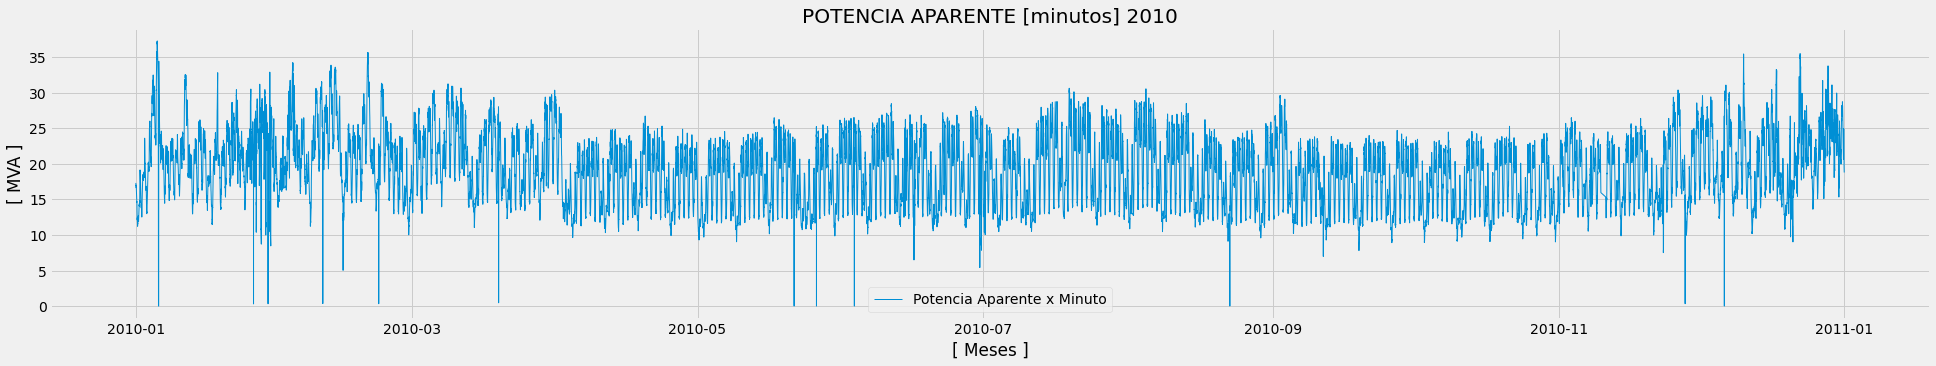

<Figure size 432x288 with 0 Axes>

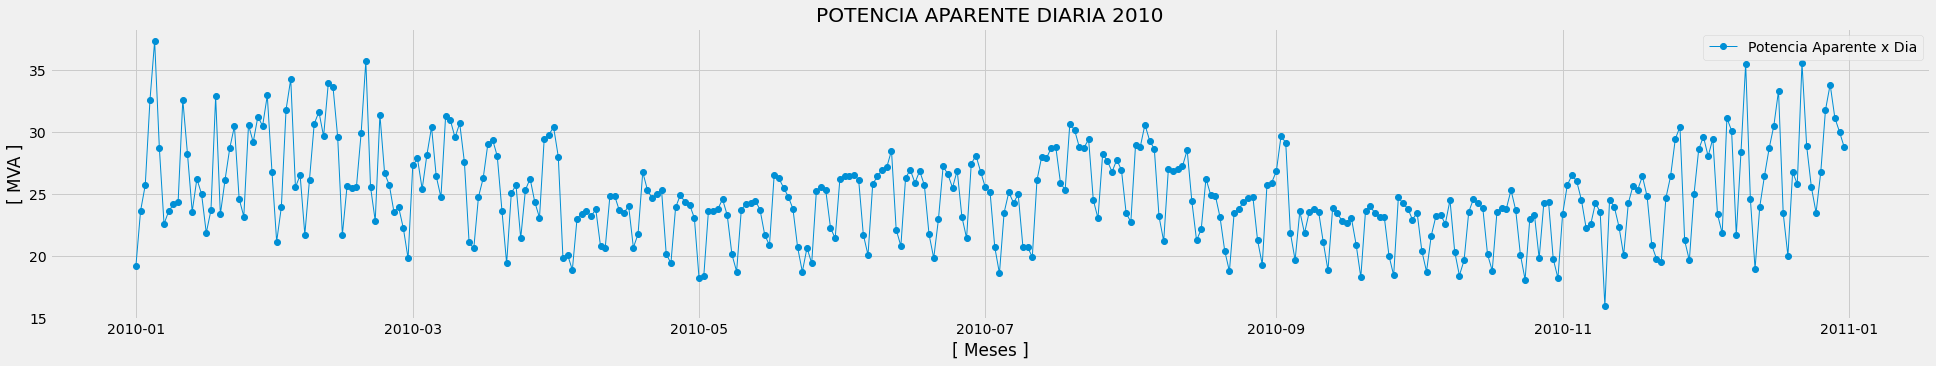

<Figure size 432x288 with 0 Axes>

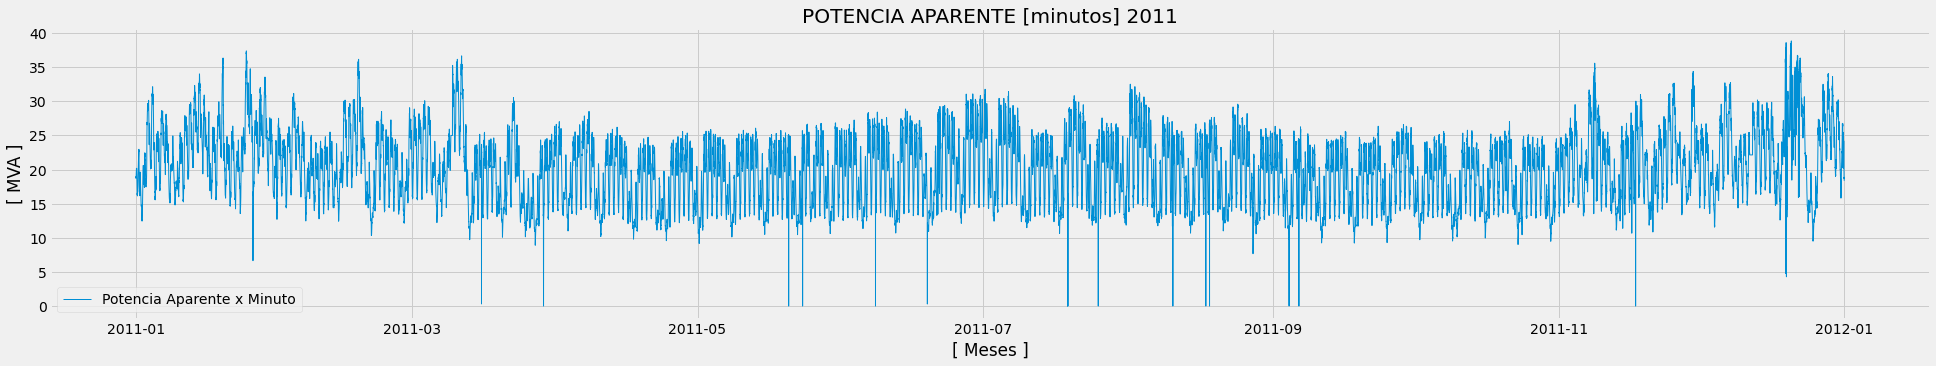

<Figure size 432x288 with 0 Axes>

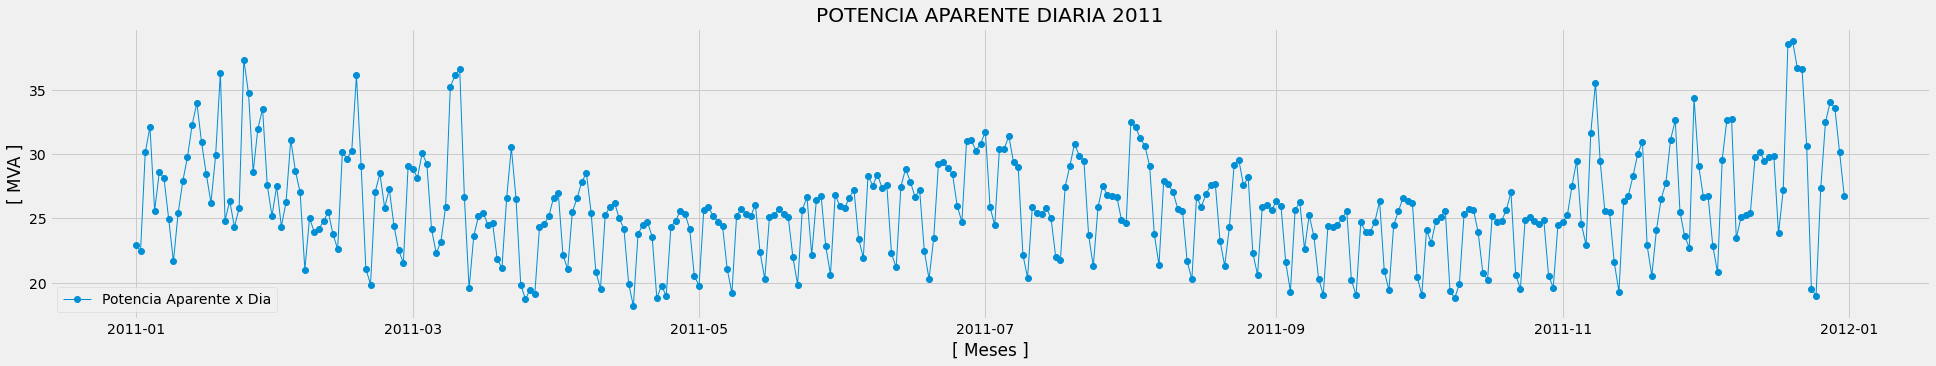

<Figure size 432x288 with 0 Axes>

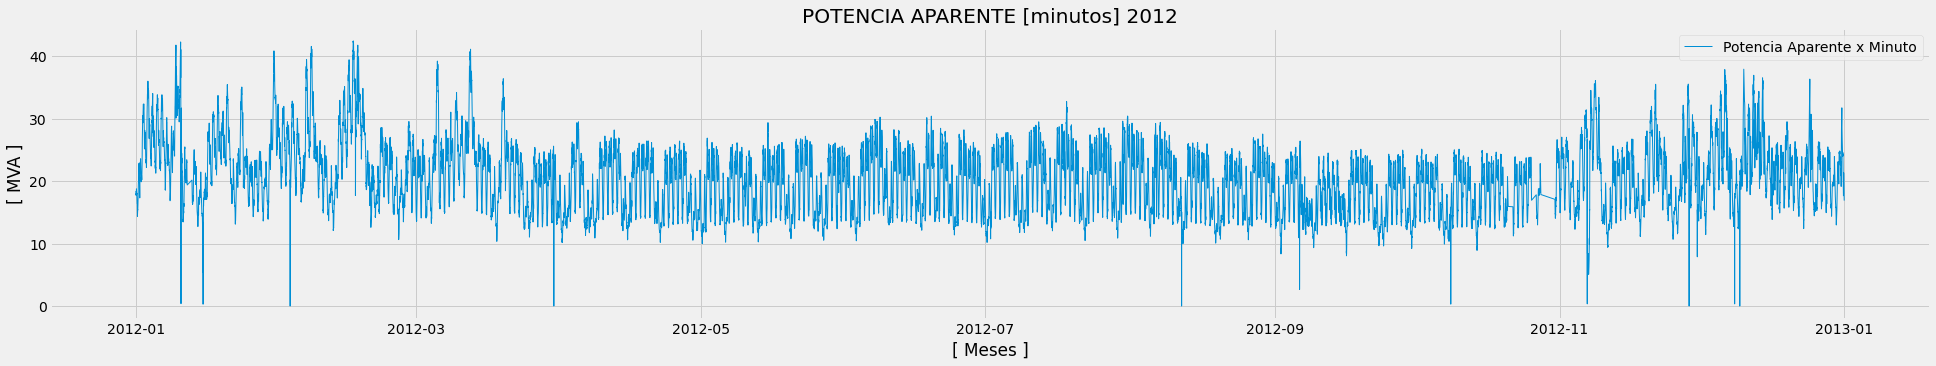

<Figure size 432x288 with 0 Axes>

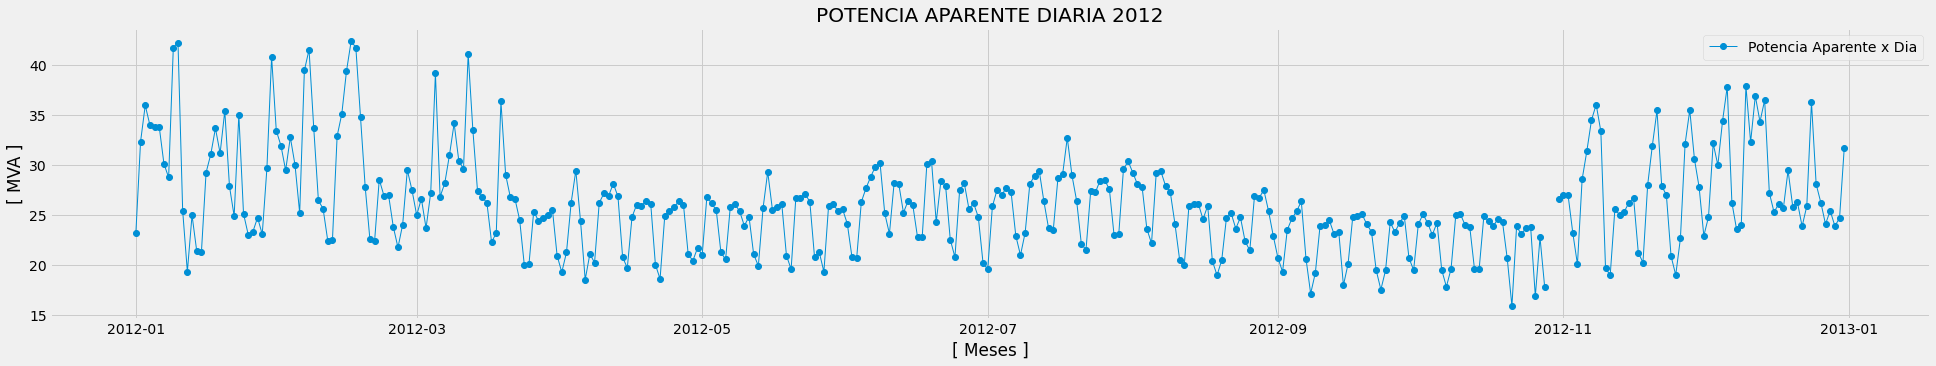

<Figure size 432x288 with 0 Axes>

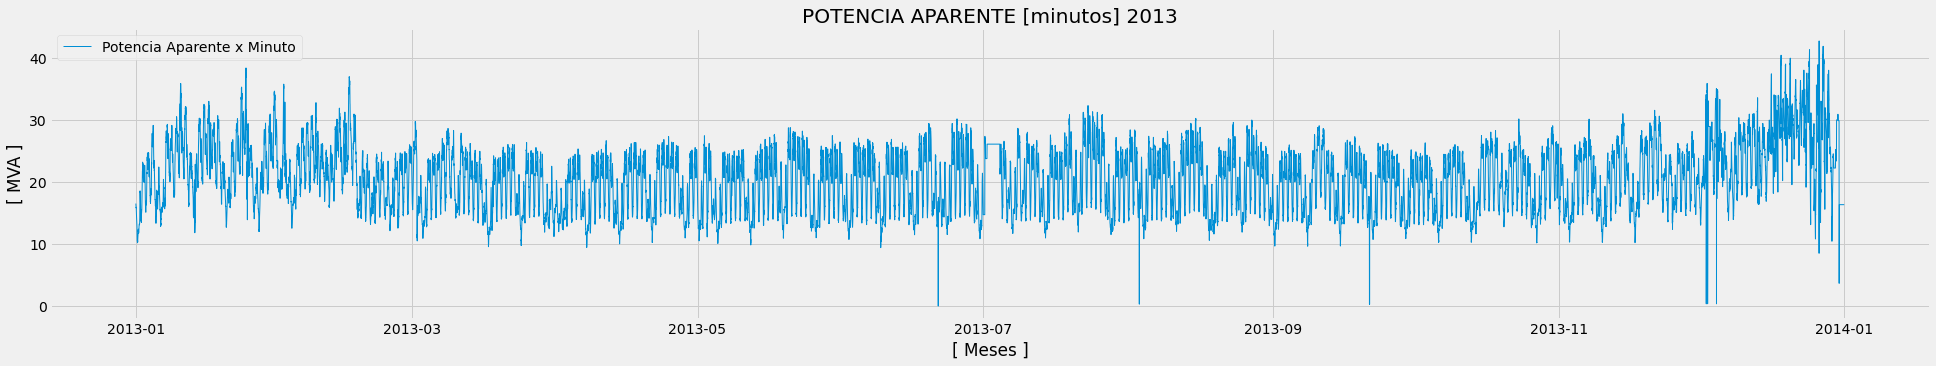

<Figure size 432x288 with 0 Axes>

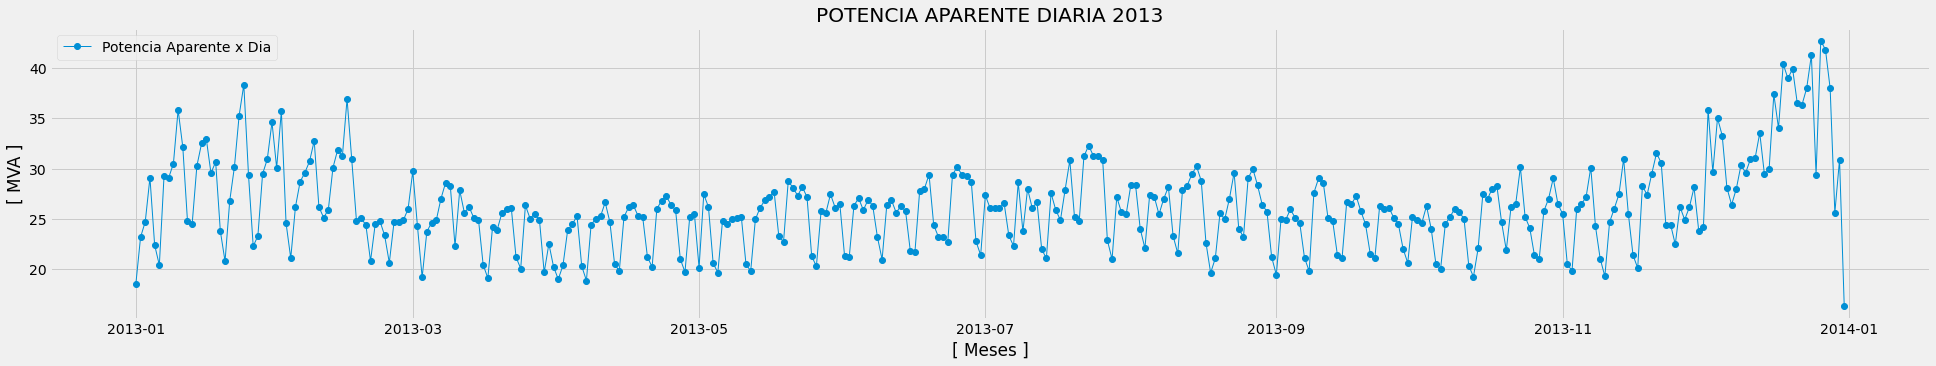

<Figure size 432x288 with 0 Axes>

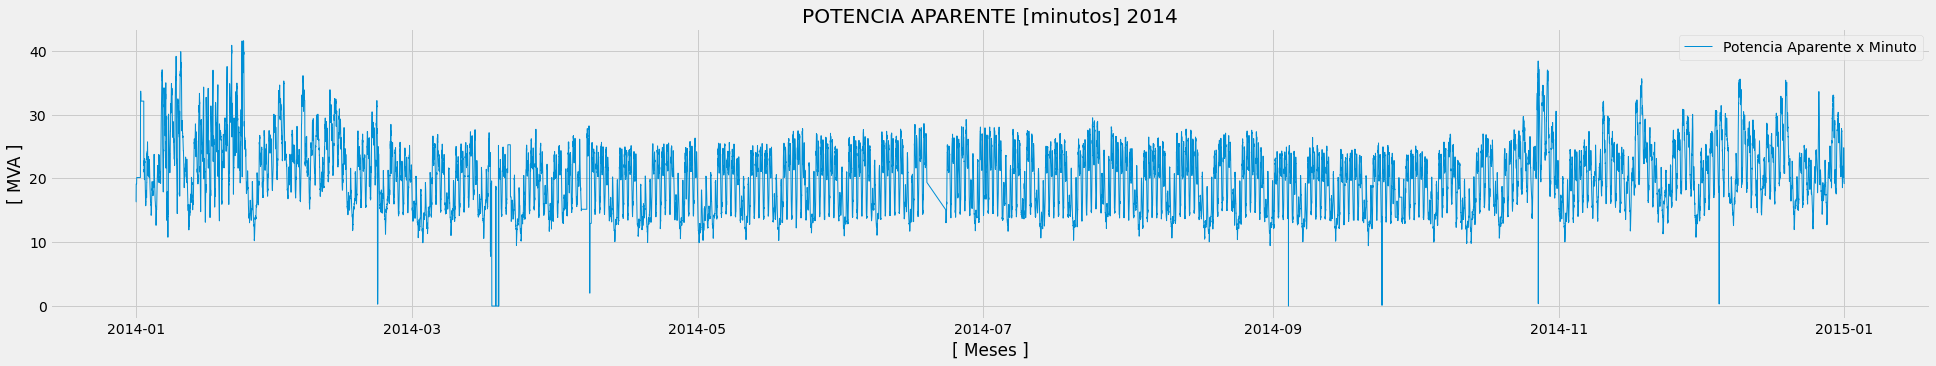

<Figure size 432x288 with 0 Axes>

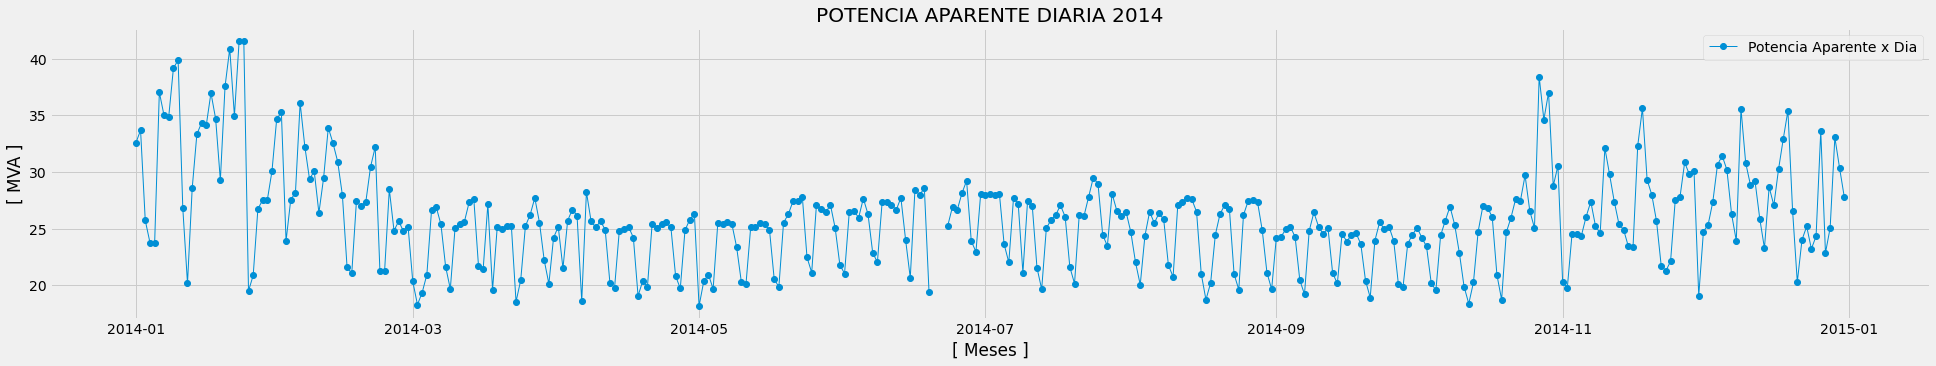

<Figure size 432x288 with 0 Axes>

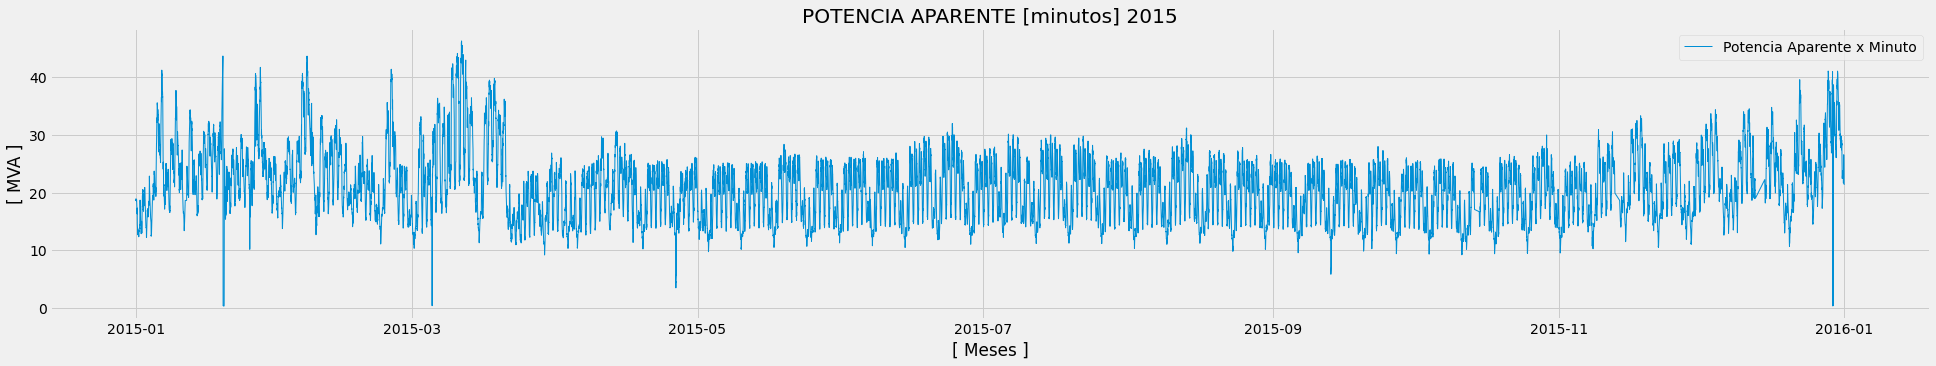

<Figure size 432x288 with 0 Axes>

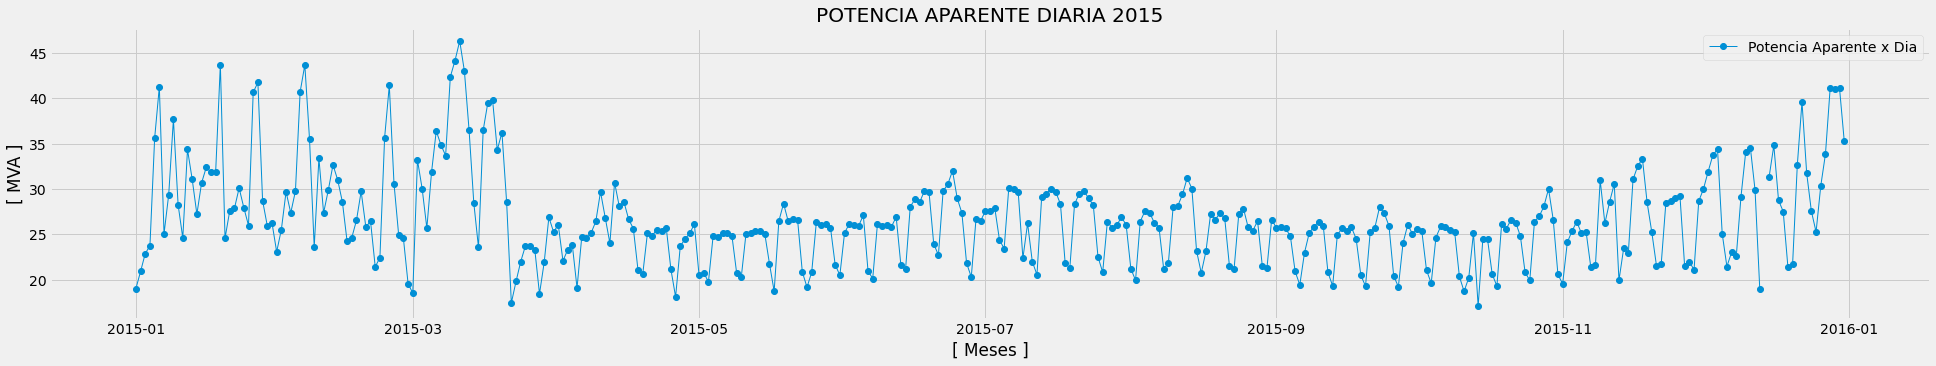

<Figure size 432x288 with 0 Axes>

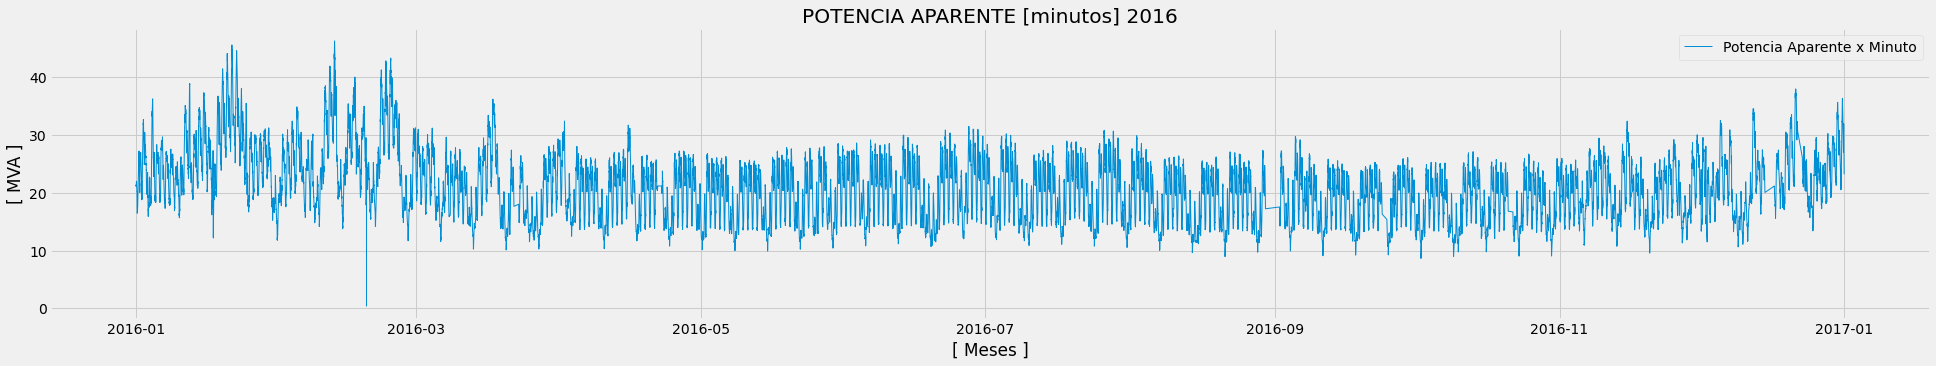

<Figure size 432x288 with 0 Axes>

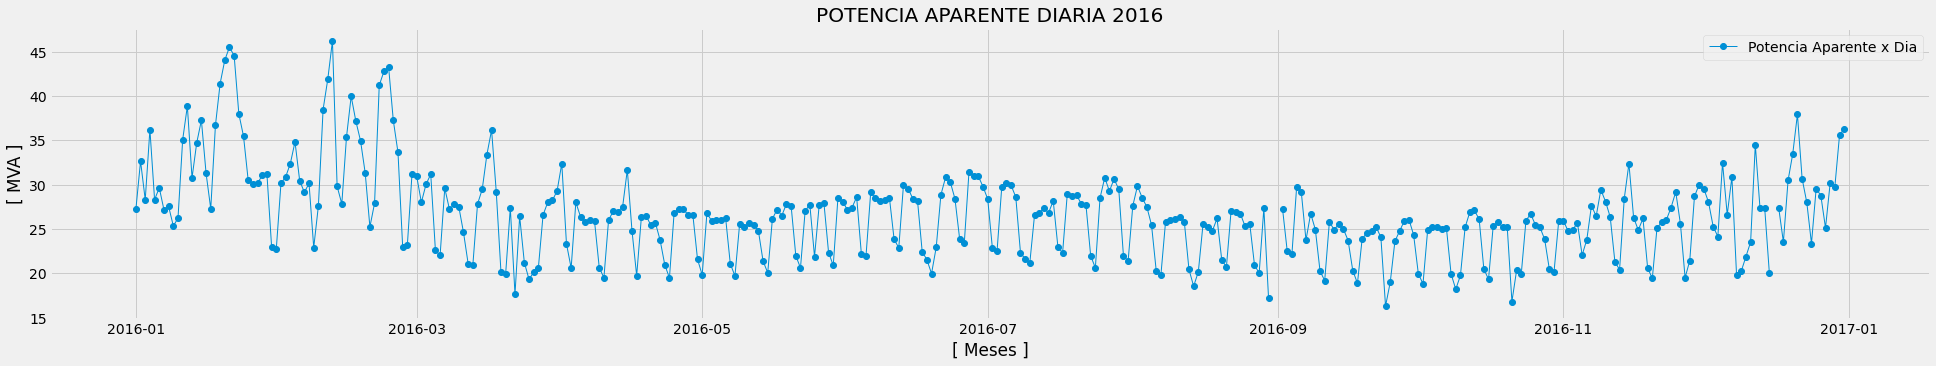

<Figure size 432x288 with 0 Axes>

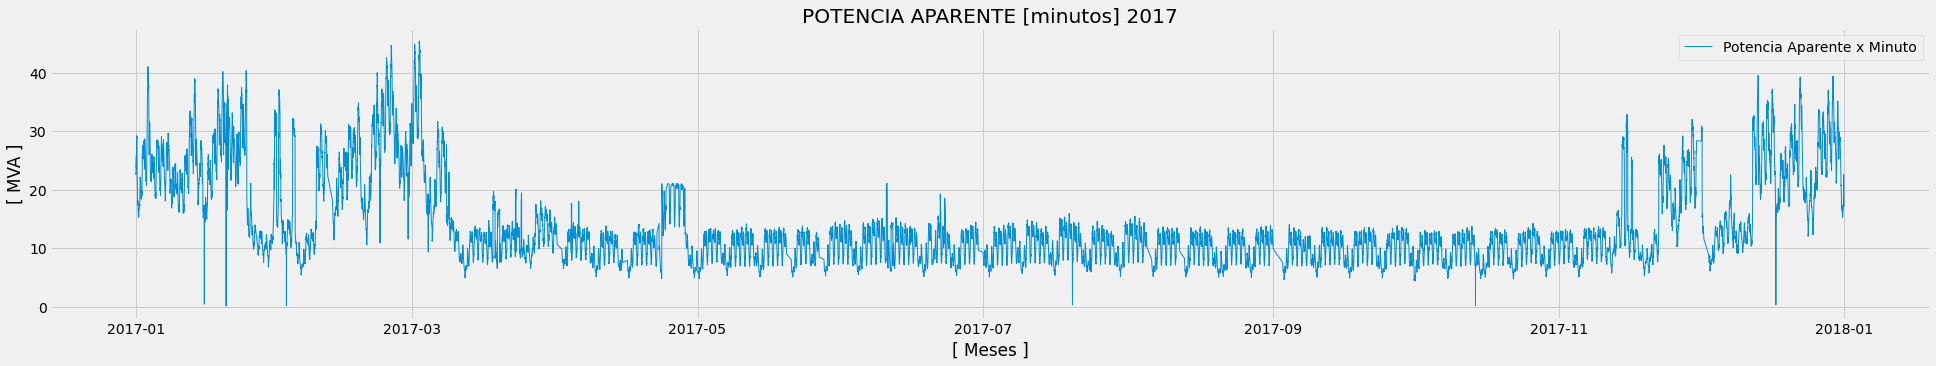

<Figure size 432x288 with 0 Axes>

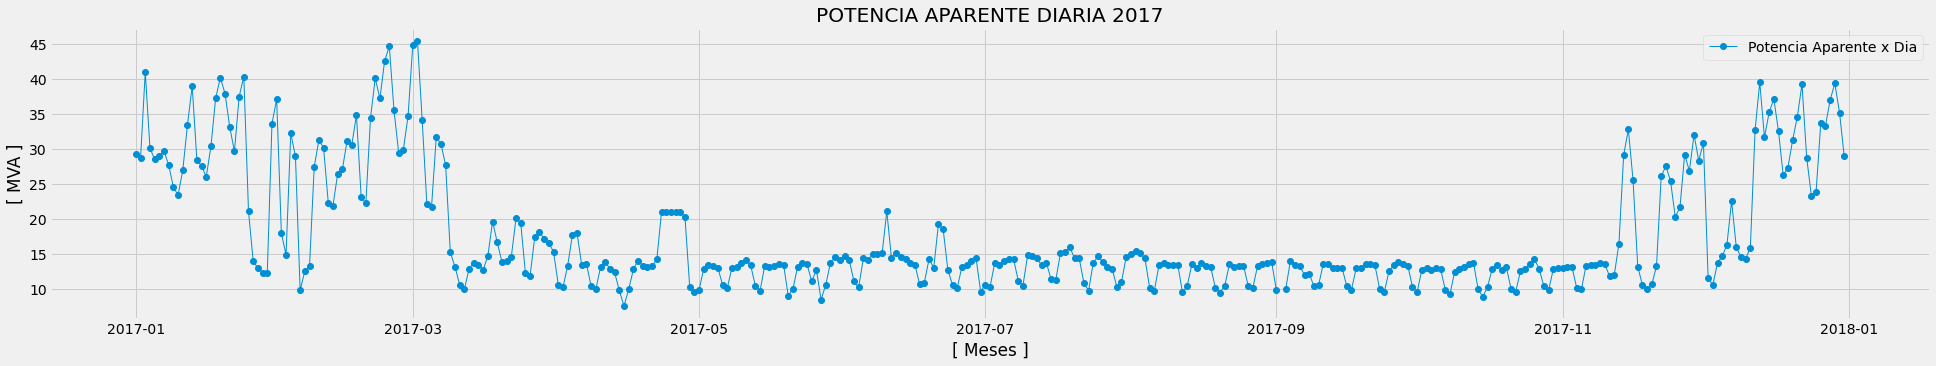

<Figure size 432x288 with 0 Axes>

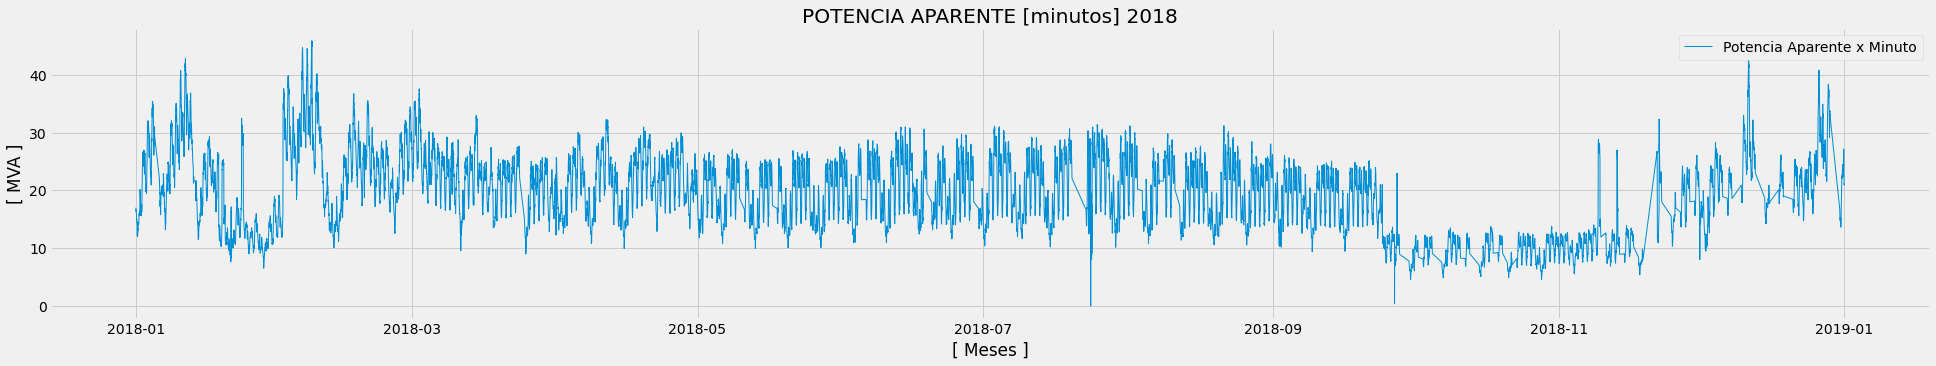

<Figure size 432x288 with 0 Axes>

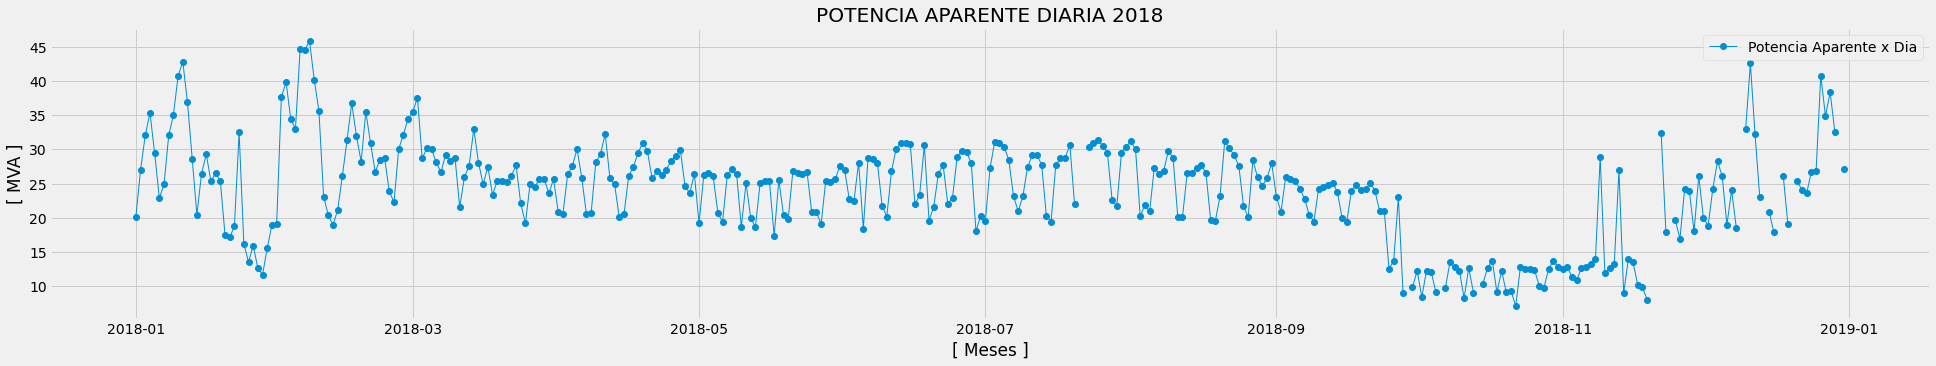

<Figure size 432x288 with 0 Axes>

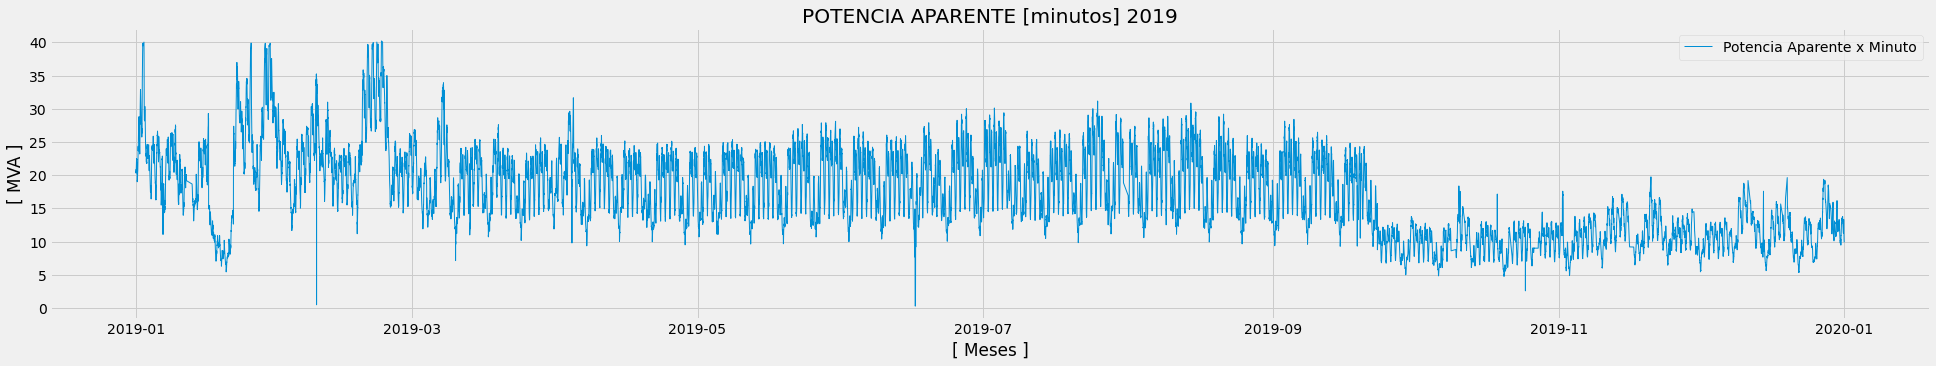

<Figure size 432x288 with 0 Axes>

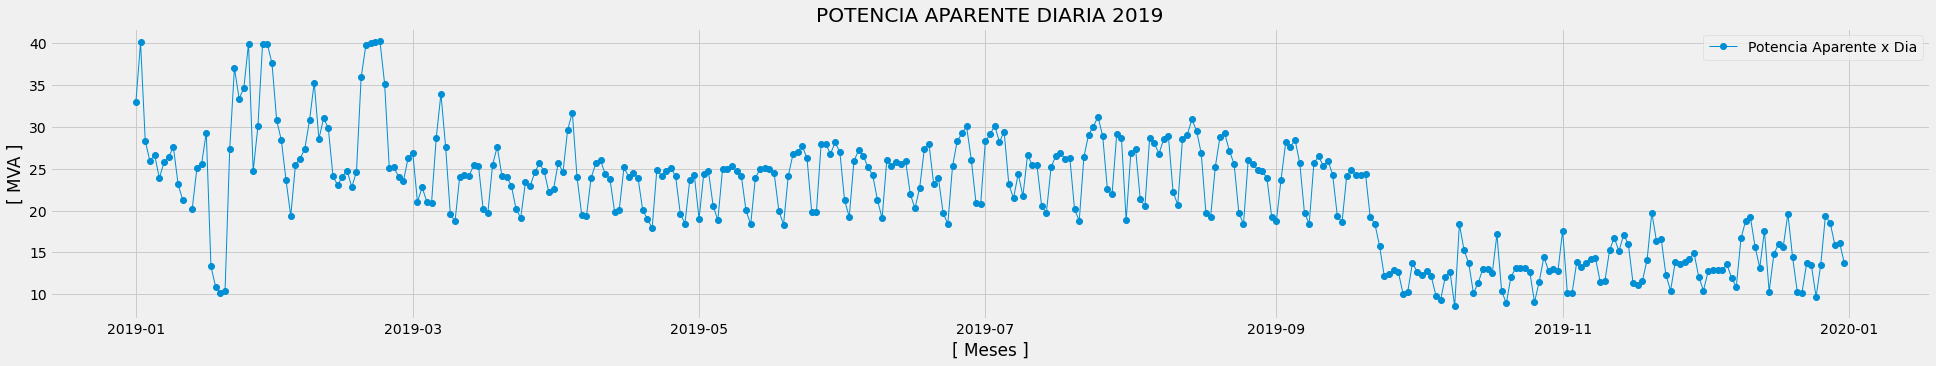

<Figure size 432x288 with 0 Axes>

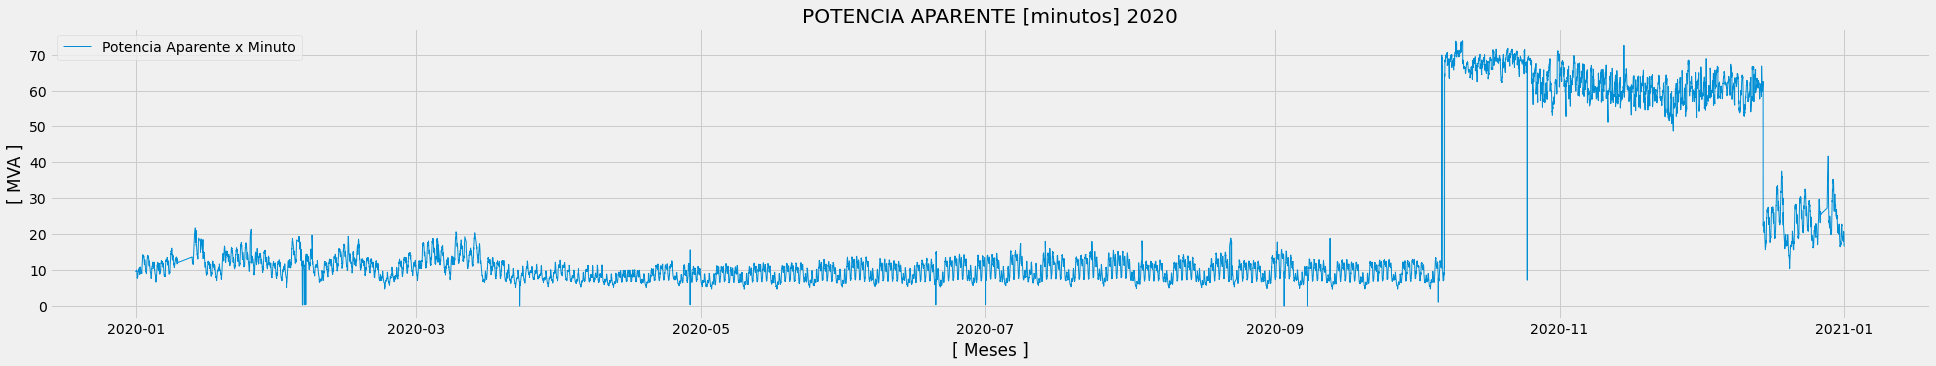

<Figure size 432x288 with 0 Axes>

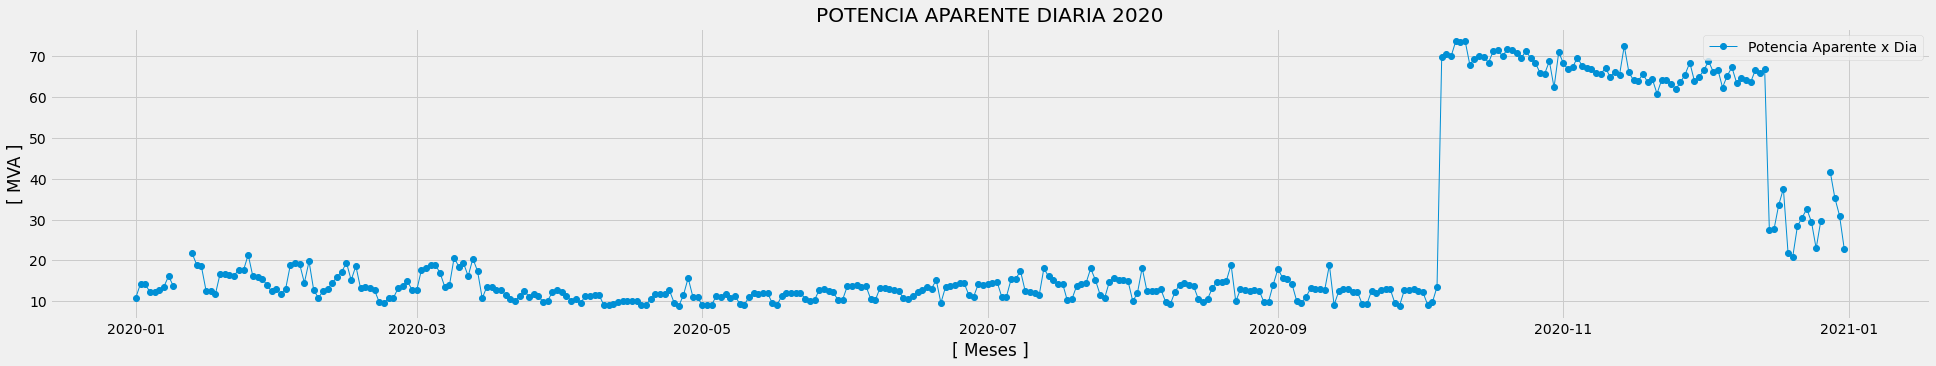

<Figure size 432x288 with 0 Axes>

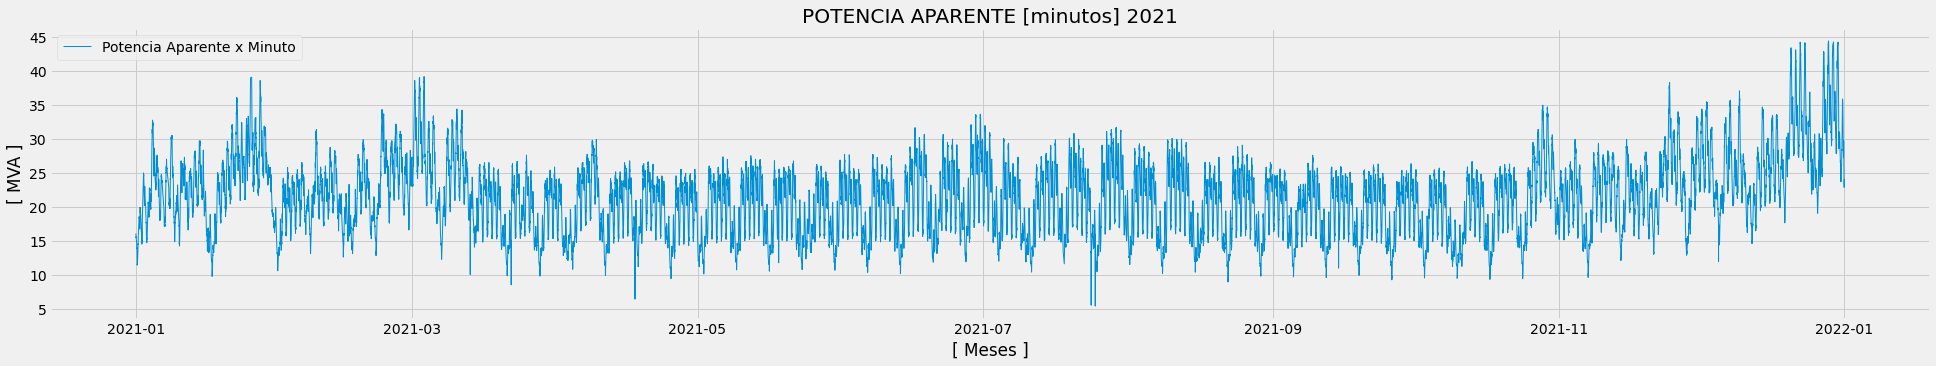

<Figure size 432x288 with 0 Axes>

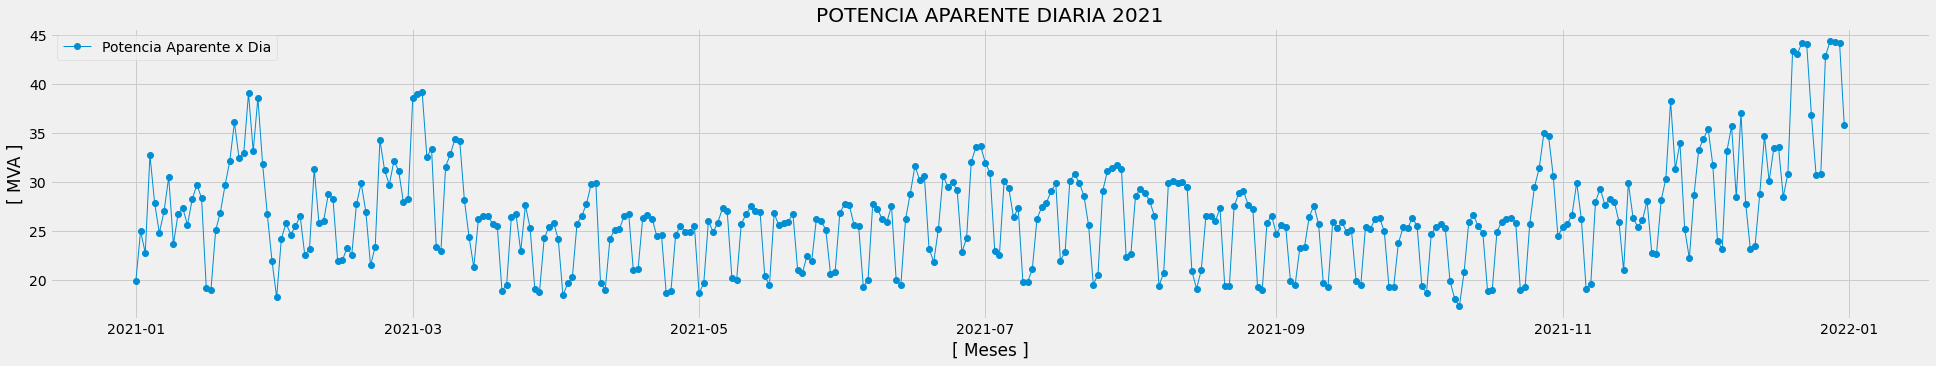

In [31]:
# LANZO LAS GRAFICAS 

anios = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

#Grafica_xSemana(anios[0], anios[-1])

for anio in anios:
    Grafica_xmin(anio, anio)
    Grafica_xDia(anio, anio)
    #Grafica_Pico_Anual(anio, anio)

## Pronosticos

### Tabla Historica

In [ ]:
# 
# GENERAR TABLA EXCEL CON LOS DATOS DEPURADOS
#
anios_hist = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']

Trafos = pd.Series([25.0, 25.0, 25.0], index=['TD1', 'TD2', 'TD3'])
POT_INSTALADA = Trafos.sum()

Historica = pd.DataFrame(columns = ['FECHA_HORA', 'P_MW', 'Q_MVAR', 'S_MVA'])

for anio in anios_hist:
    #Anio = pd.to_numeric(anio)
    fecha_hora_i = datos.loc[anio:anio, 'MVA'].idxmax()
    maximo_p     = datos.loc[fecha_hora_i, 'MW'].max()
    maximo_q     = datos.loc[fecha_hora_i, 'MVAR'].max()
    maximo_s     = datos.loc[fecha_hora_i, 'MVA'].max()
    Historica.loc[anio] = [fecha_hora_i, maximo_p, maximo_q, maximo_s]  
    
# Columnas derivadas
Historica['POT_INSTALADA'] = POT_INSTALADA
Historica['CRECIMIENTO_%'] = Historica['S_MVA'].pct_change().mul(100)
Historica['N-1'] = Historica['POT_INSTALADA'] - Trafos.max()   
Historica['CARGA_%'] = Historica['S_MVA'] / Historica['POT_INSTALADA'] * 100
Historica['ANIO'] = pd.to_numeric(Historica.index)

nombres_columnas = ['ANIO', 'FECHA_HORA', 'P_MW', 'Q_MVAR', 'S_MVA', 'CRECIMIENTO_%', 'POT_INSTALADA', 'N-1', 'CARGA_%']
Historica = Historica.reindex(columns=nombres_columnas)
Historica

In [ ]:
Historica.index

### Regresion Lineal

In [ ]:
pd.set_option('display.float_format', '{:.8f}'.format)
import statsmodels.formula.api as smf
lm = smf.ols(formula="S_MVA~ANIO", data = Historica).fit()
lm.summary2()

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)

Historica['S_MVA_PRED'] = lm.predict(Historica['ANIO'])

nombres_columnas = ['ANIO', 'FECHA_HORA', 'P_MW', 'Q_MVAR', 'S_MVA', 'CRECIMIENTO_%', 'S_MVA_PRED', 'POT_INSTALADA', 'N-1', 'CARGA_%']
Historica = Historica.reindex(columns=nombres_columnas)
Historica

In [ ]:
print('Parametros : ', lm.params) 
print('R2 : ', lm.rsquared)

### Tabla de Pronosticos

In [ ]:
#
#  AGREGO LOS AÑOS DE PRONOSTICO PROPIAMENTE DICHO
#
#Pronostico  = Tablaxls.copy()
pd.set_option('display.float_format', '{:.2f}'.format)
anios_pro = ['2021', '2022', '2023', '2024', '2025', '2026']
POT_INSTALADA = Trafos.sum()
Precaucion    = POT_INSTALADA - Trafos.max()

Anio = pd.Series(pd.to_numeric(anios_pro), index=anios_pro)
Fecha_Hora = pd.Series(np.nan, index= anios_pro)
P_MW   = pd.Series(np.nan, index=anios_pro)
Q_MVAR = pd.Series(np.nan, index=anios_pro)
S_MVA  = pd.Series(np.nan, index=anios_pro)
Crecimiento = pd.Series(np.nan, index=anios_pro)

Pronostico = pd.DataFrame({'ANIO':Anio, 
                           'FECHA_HORA':Fecha_Hora, 
                           'P_MW':P_MW, 
                           'Q_MVAR':Q_MVAR,
                           'S_MVA':S_MVA,
                           'CRECIMIENTO_%':Crecimiento}, index=anios_pro)

# El MODELO DE REGRESION LINEAL         
Pronostico['S_MVA_PRED'] = 0.51372727*Pronostico["ANIO"] - 991.015000
#
Pronostico['POT_INSTALADA'] = POT_INSTALADA
Pronostico['N-1'] = Pronostico['POT_INSTALADA'] - Trafos.max()  
Pronostico['CARGA_%'] = Pronostico['S_MVA_PRED'] / Pronostico['POT_INSTALADA'] * 100 

# nombres_columnas = ['FECHA_HORA', 'P_MW', 'Q_MVAR', 'S_MVA', 'Crecimiento %', 'Pot_Instalada', 'N-1', '% Carga']
#Tablaxls = Tablaxls.reindex(columns=nombres_columnas)

Pronostico

In [ ]:
#
# CONCATENAR LA TABLA HISTORICA + TABLA PRONOSTICO
#
Tablaxls = pd.concat([Historica,Pronostico], axis = 0)
Tablaxls

### Graficas al 2026

In [ ]:
Tablaxls.plot(kind = "line", x = "ANIO", y ="S_MVA")
plt.plot(Tablaxls["ANIO"], Tablaxls['S_MVA_PRED'], c="red", linewidth = 2)

In [ ]:
# Grafica anual de la Potencia Aparente cada 15 minutos

def Grafica_Hist_Pred():
    plt.style.use('fivethirtyeight')
    
    
    y = Tablaxls.loc['2010':'2020', 'S_MVA']
    x_y = Tablaxls.loc['2010':'2020', 'ANIO']
    
    pred = Tablaxls.loc[:, 'S_MVA_PRED']
    x_pred = Tablaxls.loc[:, 'ANIO']
    
    p_inst = Tablaxls.loc[:, 'POT_INSTALADA']
    precau = Tablaxls.loc[:, 'N-1']
    
    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(10, 5))
    #grafico.plot(x, y, lw=1, label='Potencia Aparente', marker='o')
    grafico.plot(x_y, y, lw=3, label='Pot. Aparente Hist', marker='o', color='k')
    grafico.plot(x_pred, pred, lw=3, label='Tendencia Lineal', marker='o', linestyle='dotted', color='g')
    grafico.plot(x_pred, p_inst, lw=3, label='Pot.Instalada', color='r')
    grafico.plot(x_pred, precau, lw=3, label='Precaucion N-1', color='y')
    
    grafico.set_ylim ([20,80])
    
    grafico.set_xlabel('[ Años ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("ET San Francisco: Demanda Historica y Pronostico al 2026 (Trafos + Generacion)")  # Add a title to the axes.
    grafico.legend(loc='lower right')  # Add a legend.
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid() 
    
    #fig.savefig("Serie_Anual_15min_"+anio+".png")

In [ ]:
Grafica_Hist_Pred()

In [ ]:
Tablaxls["RSE"] = (Tablaxls["S_MVA"]-Tablaxls["S_MVA_PRED"])**2
Tablaxls

In [ ]:
plt.hist((Tablaxls["S_MVA"]-Tablaxls["S_MVA_PRED"]))

In [ ]:
Tablaxls.info()

## Conclusiones